In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


 <h3> Extracting Cataract & Normal information from the Dataset </h3>

In [2]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
print(left_cataract[:10])
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
print(right_cataract[:15])

['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']


In [3]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


>Normal Images

In [4]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [5]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [6]:
print(len(cataract),len(normal))

594 600


><h3>Creating Dataset from images</h3>

In [7]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset
        

In [8]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:05<00:00, 115.07it/s]


In [9]:
len(dataset)

588

In [10]:
dataset = create_dataset(normal,0)

100%|██████████| 600/600 [00:06<00:00, 87.61it/s]


In [11]:
len(dataset)

1188

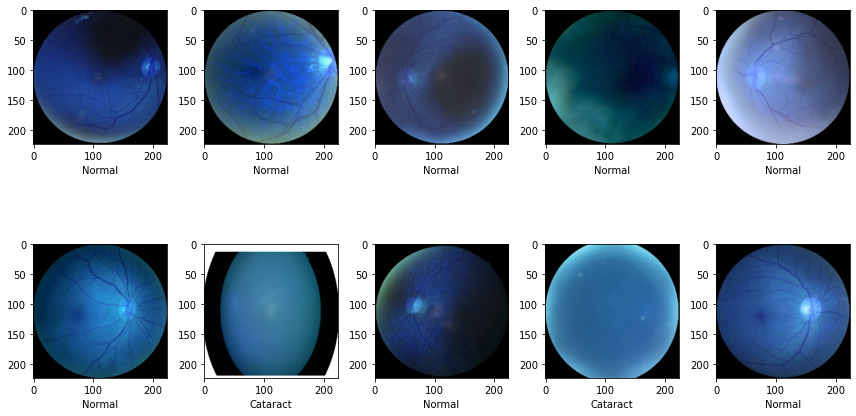

In [12]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

><h3>Dividing dataset into x(features) & y(target)</h3>

In [13]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [14]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2)
x_val,x_test,y_val,y_test = train_test_split(x_val,y_val,test_size=0.5)

print(len(x_train))
print(len(x_val))
print(len(x_test))

950
119
119


><h3>Creating Model</h3>

In [15]:
from keras.applications.vgg16 import VGG16, preprocess_input
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg = VGG16(weights=vgg16_weight_path,include_top=False, input_shape=(224,224,3)
)

In [16]:
for layer in vgg.layers:
    layer.trainable = False

In [17]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(Dense(128, activation='sigmoid'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 256)         131328    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 128)         32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 128)         16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import tensorflow as tf
def get_callbacks(model_name):
    callbacks =[]
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'model.{model_name}.h5',
        verbose=1,
         monitor='val_acc',
    mode='max',
    save_best_only=True)
    # erly = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    callbacks.append(checkpoint)
    # callbacks.append(erly)
    return callbacks

In [21]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [22]:
callbacks = get_callbacks('cnn')
history = model.fit(x_train,y_train,batch_size=32,epochs=2,validation_data=(x_test,y_test),callbacks=[callbacks])

Epoch 1/2
30/30 [==============================] - 4s 121ms/step - loss: 0.4490 - accuracy: 0.7811 - val_loss: 0.1608 - val_accuracy: 0.9328
Epoch 2/2
30/30 [==============================] - 2s 68ms/step - loss: 0.1943 - accuracy: 0.9337 - val_loss: 0.1666 - val_accuracy: 0.9412


In [23]:
loss,accuracy = model.evaluate(x_val,y_val)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 0s 44ms/step - loss: 0.1470 - accuracy: 0.9580
loss: 0.1470049023628235
Accuracy: 0.9579831957817078


In [24]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
test_image = image.load_img('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/119_right.jpg', target_size=(224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

test_image = test_image.reshape(1,224,224,3)    # Ambiguity!
# Should this instead be: test_image.reshape(img_width, img_height, 3) ??

result = model.predict(test_image, batch_size=1)
print (result[0])



[0.00172382]


In [25]:
model.save('model.h5')

In [ ]:
!pip install streamlit

In [ ]:
import streamlit as st
st.set_option('deprecation.showFileUploaderEncoding', False)

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict_classes(x_val)

2021-07-23 19:32:05.846 WARNING tensorflow: From <ipython-input-29-80392416d47f>:2: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [30]:
accuracy_score(y_val,y_pred)

0.957983193277311

In [31]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96        58
           1       0.95      0.97      0.96        61

    accuracy                           0.96       119
   macro avg       0.96      0.96      0.96       119
weighted avg       0.96      0.96      0.96       119



><h3>Prediction:</h3>

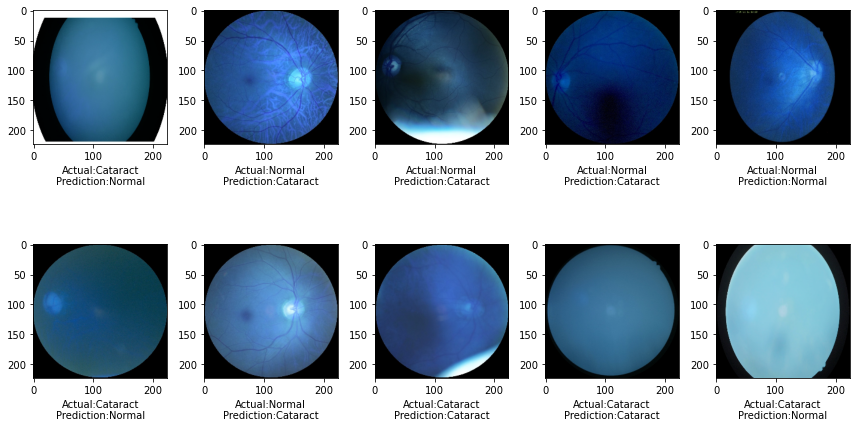

In [32]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

In [33]:
clf=model
p=0
q=1
prediction_train = clf.predict(x_train)
prediction_test = clf.predict(x_test)
# prediction_train = [1 if x>0.5 else 0 for x in prediction_train]
for i in range(len(prediction_train)):
    if(prediction_train[i]>0.5):
        prediction_train[i]=1
    else:
        prediction_train[i]=0
        
for i in range(len(prediction_test)):
    if(prediction_test[i]>0.5):
        prediction_test[i]=1
    else:
        prediction_test[i]=0     

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
evaluation = pd.DataFrame({'Model': [],
                           'Accuracy(train)':[],
                           'Precision(train)':[],
                           'Recall(train)':[],
                           'F1_score(train)':[],
                           'Specificity(train)':[],
                           'Accuracy(test)':[],
                           'Precision(test)':[],
                           'Recalll(test)':[],
                           'F1_score(test)':[],
                           'Specificity(test)':[],
                          })
print(x_train.shape)
clf=model
acc_train=format(accuracy_score(prediction_train, y_train),'.3f')
precision_train=format(precision_score(y_train, prediction_train, average='binary'),'.3f')
recall_train=format(recall_score(y_train,prediction_train, average='binary'),'.3f')
f1_train=format(f1_score(y_train,prediction_train, average='binary'),'.3f')
tn, fp, fn, tp = confusion_matrix(prediction_train, y_train).ravel()
specificity = tn / (tn+fp)
specificity_train=format(specificity,'.3f')

acc_test=format(accuracy_score(prediction_test, y_test),'.3f')
precision_test=format(precision_score(y_test, prediction_test, average='binary'),'.3f')
recall_test=format(recall_score(y_test,prediction_test, average='binary'),'.3f')
f1_test=format(f1_score(y_test,prediction_test, average='binary'),'.3f')
tn, fp, fn, tp = confusion_matrix(prediction_test, y_test).ravel()
specificity = tn / (tn+fp)
specificity_test=format(specificity,'.3f')

r = evaluation.shape[0]
evaluation.loc[r] = ['Neural Network',acc_train,precision_train,recall_train,f1_train,specificity_train,acc_test,precision_test,recall_test,f1_test,specificity_test]
evaluation.sort_values(by = 'Accuracy(test)', ascending=False)

(950, 224, 224, 3)


,Model,Accuracy(train),Precision(train),Recall(train),F1_score(train),Specificity(train),Accuracy(test),Precision(test),Recalll(test),F1_score(test),Specificity(test)
0,Neural Network,0.945,0.935,0.955,0.945,0.956,0.941,0.950,0.934,0.942,0.932


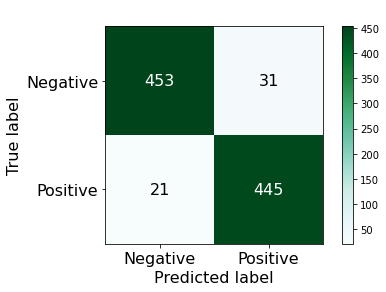

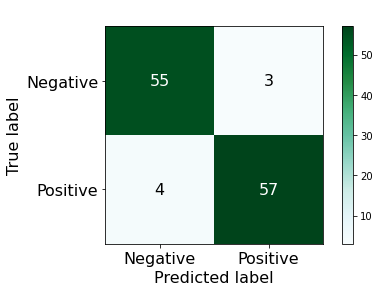

In [35]:
import scikitplot as skplt
p=y_train
q=y_test

y_train = pd.DataFrame(y_train)
y_train=y_train.replace([0,1], ["Negative","Positive"])


pred_train=prediction_train
pred_train=pd.DataFrame(pred_train)
pred_train=pred_train.replace([0,1], ["Negative","Positive"])


pred_test=prediction_test
y_test = pd.DataFrame(y_test)
y_test=y_test.replace([0,1], ["Negative","Positive"])
pred_test=pd.DataFrame(pred_test)

pred_test=pred_test.replace([0,1], ["Negative","Positive"])

skplt.metrics.plot_confusion_matrix(
    y_train, 
    pred_train,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )

skplt.metrics.plot_confusion_matrix(
    y_test, 
    pred_test,
    figsize=(7,4),
    title_fontsize='18',
    text_fontsize='16',
    title =' ',
    cmap='BuGn'
    )
y_train=p
y_test=q

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


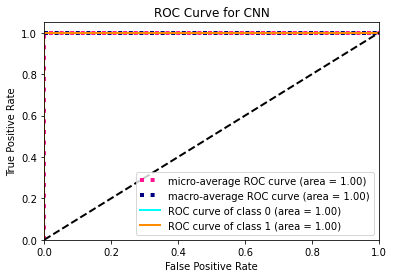

In [36]:
# n_samples, n_features = X.shape
y_score = prediction_test
n_classes = 2
#Create another array arr2 with size of arr1    
roc_y_test = prediction_test
    
y_score[50]=2
roc_y_test[50]=2
y_test
from sklearn.preprocessing import label_binarize
y_score = label_binarize(y_score, classes=[1, 0])
roc_y_test = label_binarize(roc_y_test, classes=[1, 0])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(roc_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(roc_y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])




# First aggregate all false positive rates
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")
plt.show()